RF to predict tti or log tti or ahd from all other data
 use households until find pop
dimensionality reduction?

factorsd impacting congestion, networks, tti, modeshares

tti website has other papers
modeshare variables
feature importance what is the direction of impact (negative vs. positive, impurity)
plot to show errors from rf optimization, 2d contour plot
rf/gbm as feature extractor
pca, condense and explain
kernel pca
update manuscript
final model (generalize additive model)
poster

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance


# set pandas column display to none
pd.set_option('display.max_columns', None)


In [5]:
trf = pd.read_csv('../../data/tidy/tti-traffic19-renamed.csv')
net = pd.read_csv('../../data/tidy/data-aggregation-networkstats.csv')
inc = pd.read_csv('../../data/tidy/acs19-hh-income.csv')
mod = pd.read_csv('../../data/tidy/acs19-modeshares.csv')
unemp = pd.read_csv('../../data/tidy/acs19-unemp.csv')
pop = pd.read_csv('../../data/tidy/acs19-pop.csv')

In [6]:
df = trf.merge(net, on='msa', how='left')
df = df.merge(mod, left_on='msa', right_on='msa', how='inner')
df = df.merge(unemp, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.merge(inc, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.merge(pop, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.dropna(subset=['tti'])
# df = df.set_index('msa')
# df['log_tti'] = np.log10(df['tti'])


In [7]:
from pathlib import Path  
filepath = Path('../../data/tidy/congestion-exploration19_MM.csv', index = False)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

--------------------------
## Jimi suggestions:
- Comulative feature importance for feature selection based on Random Forests (select the top features), then:
- PCA then PCR
- PCA then GAM
- PCA to RF
- KPCA

--------------------------  

In [8]:
data = df.copy()
# Set 'msa' column as index
data = data.set_index('msa')
data.head()

,auto_commuters,annual_excess_fuel_consumed_commuters,ahd_ph,tti,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,circuity_avg,self_loop_proportion,node_density_km,intersection_density_km,edge_density_km,street_density_km,builing_area_sqkm,area_sqkm,ms_cara_per,ms_carp_per,ms_pt_per,ms_taxi_per,ms_bike_per,ms_walk_per,ms_wfh_per,unemp,med_hh_inc_dol,households,population
msa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Abilene, TX",64,1282,2548,1.07,14357,39401,5.488751,1.716897e+07,435.749497,2.881452,11912,8.925436e+06,20606,433.147439,1.067840,0.004465,2.012523,1.669790,2406.696840,1251.142264,7.048505,7133.829924,80.291133,100.105752,0.510579,0.915432,0.265604,1.943037,5.499039,3.4,52511,60931,170669
"Akron, OH",298,6741,15835,1.10,26865,70900,5.278243,1.519199e+07,214.273426,2.756896,21200,8.039295e+06,36980,217.395754,1.056240,0.015089,11.231303,8.862967,6351.230011,3360.943838,14.307097,2391.975398,84.673598,100.071737,1.303214,0.614118,0.096859,1.592914,4.545640,5.4,57285,286543,703845
"Albany, GA",54,870,1905,1.08,8466,22838,5.395228,9.545102e+06,417.948256,2.837468,6957,4.989593e+06,11954,417.399446,1.052833,0.002928,2.028965,1.667318,2287.583389,1195.808038,6.979580,4172.570196,81.190732,100.114382,0.995359,0.906248,0.131145,1.585513,3.752774,10.6,44844,55714,148436
"Albany-Lebanon, OR",35,465,1046,1.06,7132,17906,5.021312,8.280294e+06,462.431276,2.568144,5101,4.225439e+06,9147,461.948061,1.150205,0.005466,1.193324,0.853498,1385.456359,706.999160,7.519705,5976.582645,79.296969,100.111969,0.170747,1.503313,0.645868,2.225274,4.960932,6.6,55893,47762,125048
"Albany-Schenectady-Troy, NY",297,6240,15617,1.15,36977,96867,5.239311,2.787244e+07,287.739291,2.755794,30254,1.455542e+07,50900,285.961192,1.091565,0.033320,4.962653,4.060365,3740.737967,1953.471821,41.455466,7451.054339,79.338492,100.080156,3.618297,0.859834,0.280518,3.332137,4.555087,4.6,71285,352713,880736


calculating the cumulative feature importance using a Random Forest model.

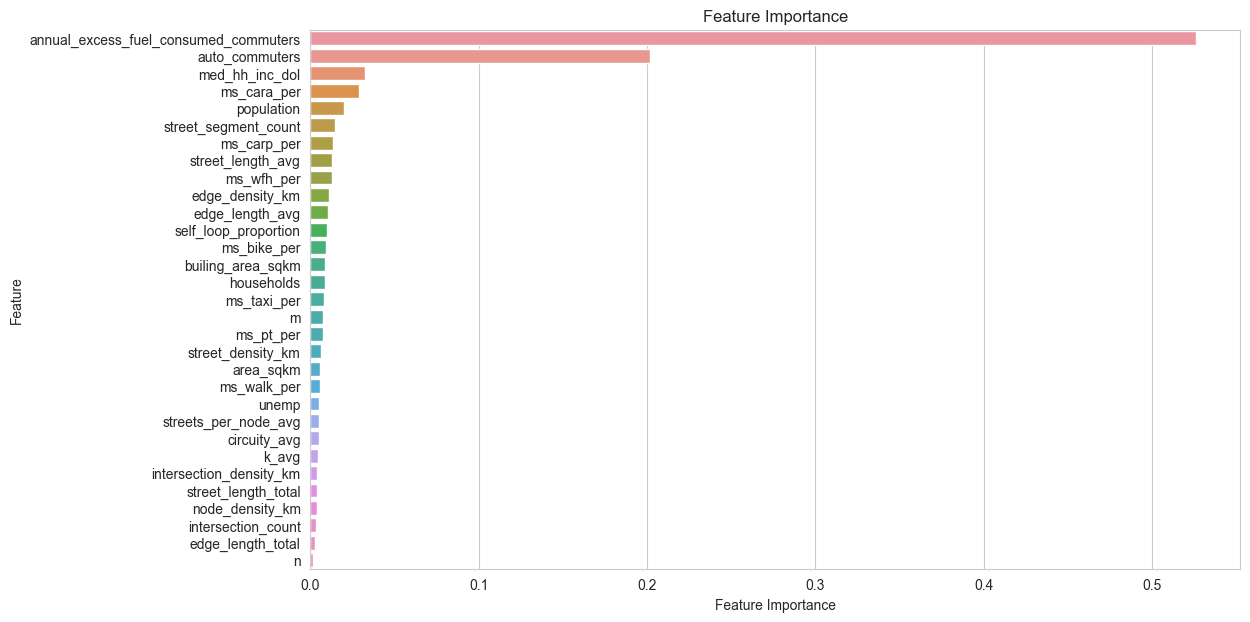

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Define the features and target
X = data.drop(columns=['tti']) # drop the target and the ahd_ph column
X = X.drop(columns=['ahd_ph']) 
y = data['tti'] 

# Create a Random Forest Regressor
rf = RandomForestRegressor( random_state=42, n_estimators=100, max_depth=10)

# Train the model
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

importances_df  = feature_importances.copy()

# plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


- 'annual_excess_fuel_consumed_commuters', and 'auto_commuters' are the most important features in predicting 'tti'.

## Decide on a cutoff for feature selection
- We might choose to only consider features that contribute at least 1% of the total importance. (This gived 10 features)
    - Or, we might select the features that contribute a sum of 95%  (gives 18 features)


- Best result is when we select the top 13 features (which contribute 90% of the total importance) so write code that selects the top features that contribute 90% of the total importance.


##### Plot the cumulative importance of the top features and select the number of features we want to keep.

C:\Users\mazee\AppData\Local\Temp\ipykernel_32512\558329297.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importances.Feature, rotation=90)


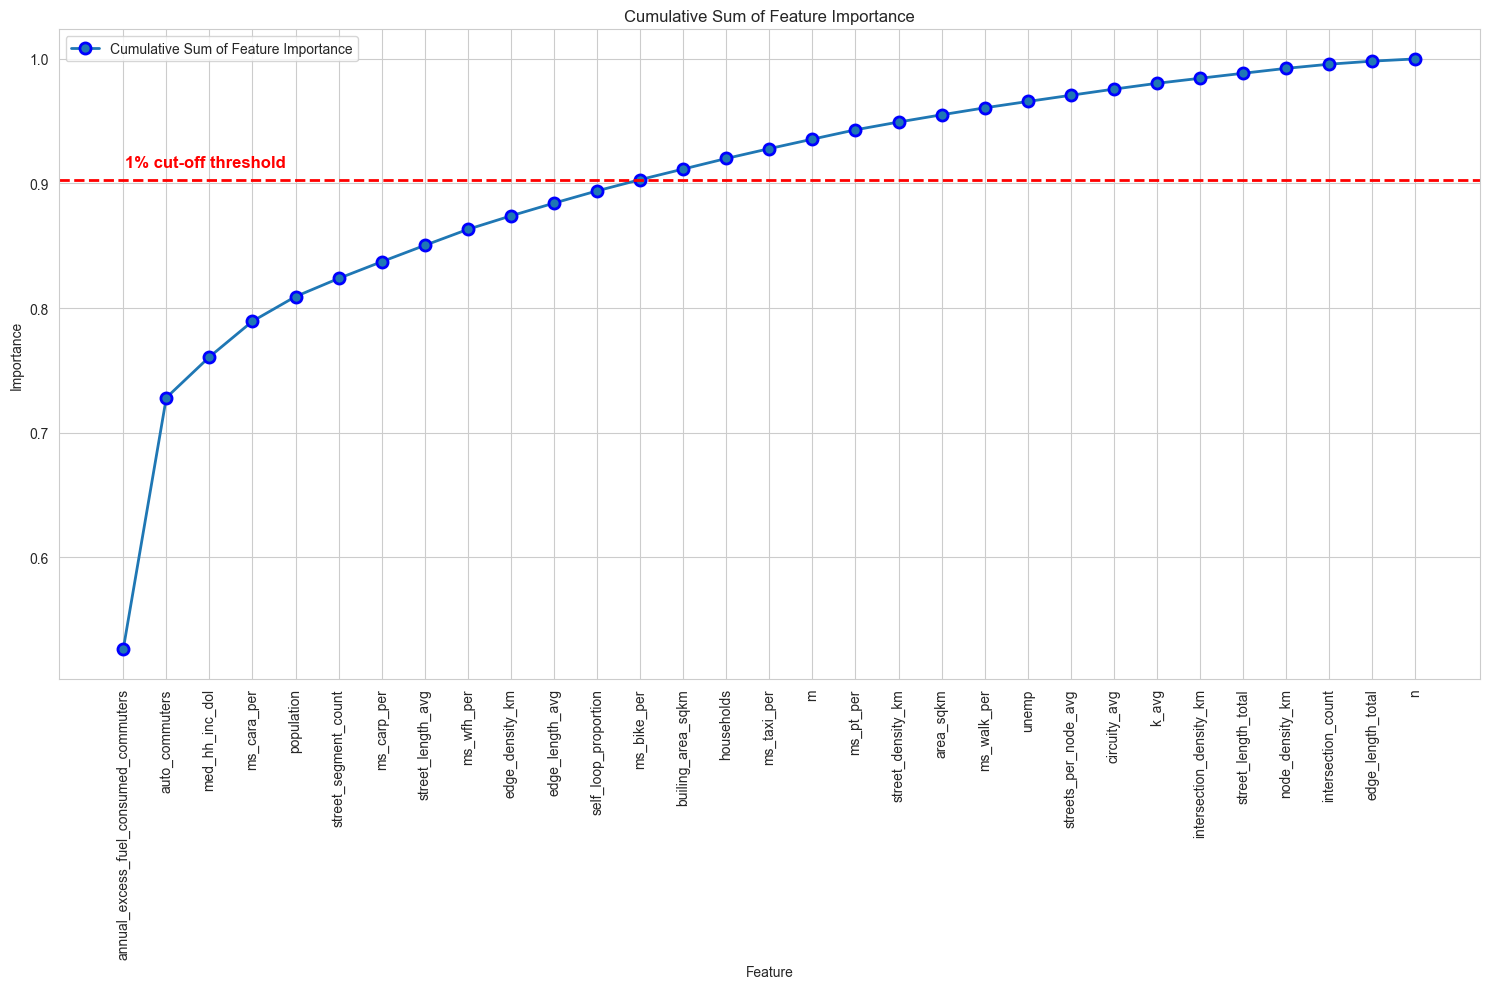

In [37]:
# find features with importance > 0.01
important_features = []
for i in range(len(importances)):
    if importances[i] > 0.009:
        important_features.append(i)
num_important_features = len(important_features)


# sort by importance and make a new column with cumulative importance from biggest to smallest
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['Importance'])
feature_importances


# make line plot with cumulative sum of feature importance from feature_importances and cut off at 95% of total importance
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x="Feature", y="cumulative_importance", ax=ax, data=feature_importances, marker='o', label='Cumulative Sum of Feature Importance', sort=False,
                linewidth=2, #color='blue',
                # markerfacecolor='blue', 
                markersize=8,
                markeredgewidth=2, 
                markeredgecolor='blue'
                )
ax.set_title('Cumulative Sum of Feature Importance')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(feature_importances.Feature, rotation=90)
# ax.set_xticks(np.arange(len(feature_importances_cumsum.index)))
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 1.1)
# make a line at the first feature the the difference between its importance and the next feature is less than 0.01 and make the line at the y value of this feature
# caculate the sum of the top features
top_sum = feature_importances.iloc[:num_important_features]['Importance'].sum()
ax.axhline(top_sum, ls='--', color='red', linewidth=2, label='95% cut-off threshold')
# add text with the cumulative importance value at the end of the line
ax.text(0.051, top_sum+0.01, '1% cut-off threshold', fontsize=12, color='red', #bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'), 
zorder=10, weight='bold')

plt.tight_layout()
plt.show()

13 features required for 90.31% of total importance


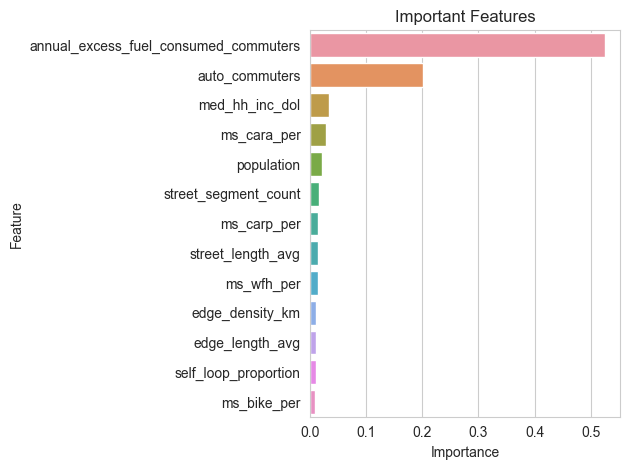

In [40]:
# Select the important features from the dataset that are the top 17
# features that contribute to 95% of the total importance
important_features = feature_importances.nlargest(num_important_features, "Importance")

# Number of important features
num_important_features = important_features.shape[0]

important_features, 


# print num_important_features
print(f"{num_important_features} features required for {100 * np.sum(important_features['Importance']):.2f}% of total importance")

# plot the important features using seaborn and make it horizontal
sns.barplot(x = "Importance", y = "Feature", data = important_features.sort_values(by = "Importance", ascending = False))
plt.title("Important Features")
plt.tight_layout()
# title
plt.title("Important Features")
plt.show()


- split the dataset into a training set and a test set.
    - 70% training set and a 30% test set

In [41]:
from sklearn.model_selection import train_test_split

# Select the important features
X_imp = X[important_features['Feature']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape


((251, 13), (108, 13))

-------------------------------
# 1. PCA followed BY PCR (Principal Component Regression)
- PCA will transform our features into a set of linearly uncorrelated components. 
    - We'll retain as many components as necessary to explain at least 95% of the variance in the data.
- PCR will then use these transformed components to fit a linear regression model.

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# Standardize the features (necessary for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA
# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


## Analyze the results of the PCA.

- Plot the cumulative explained variance by the principal components. 

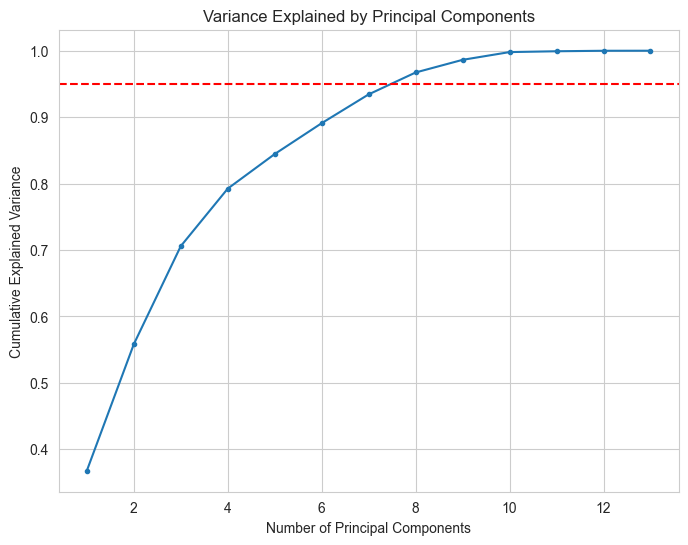

In [49]:
import matplotlib.pyplot as plt

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Create a line plot of the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker='.')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()


 ### The first few PCs capture a significant portion of the variance in the data. 
   - Over 95% of the variance is captured by the first 8 PCs.
   - Useful for dimensionality reduction.

- Create a loading plot for the top PCs to see how the original features contribute to these components to interpret them. 
    - The loading plots show the correlations between PCs and the original features. 
    - The larger the absolute value of the loading, the more the feature contributes to the principal component. 
    - A positive value indicates a positive correlation with the principal component and vice versa.

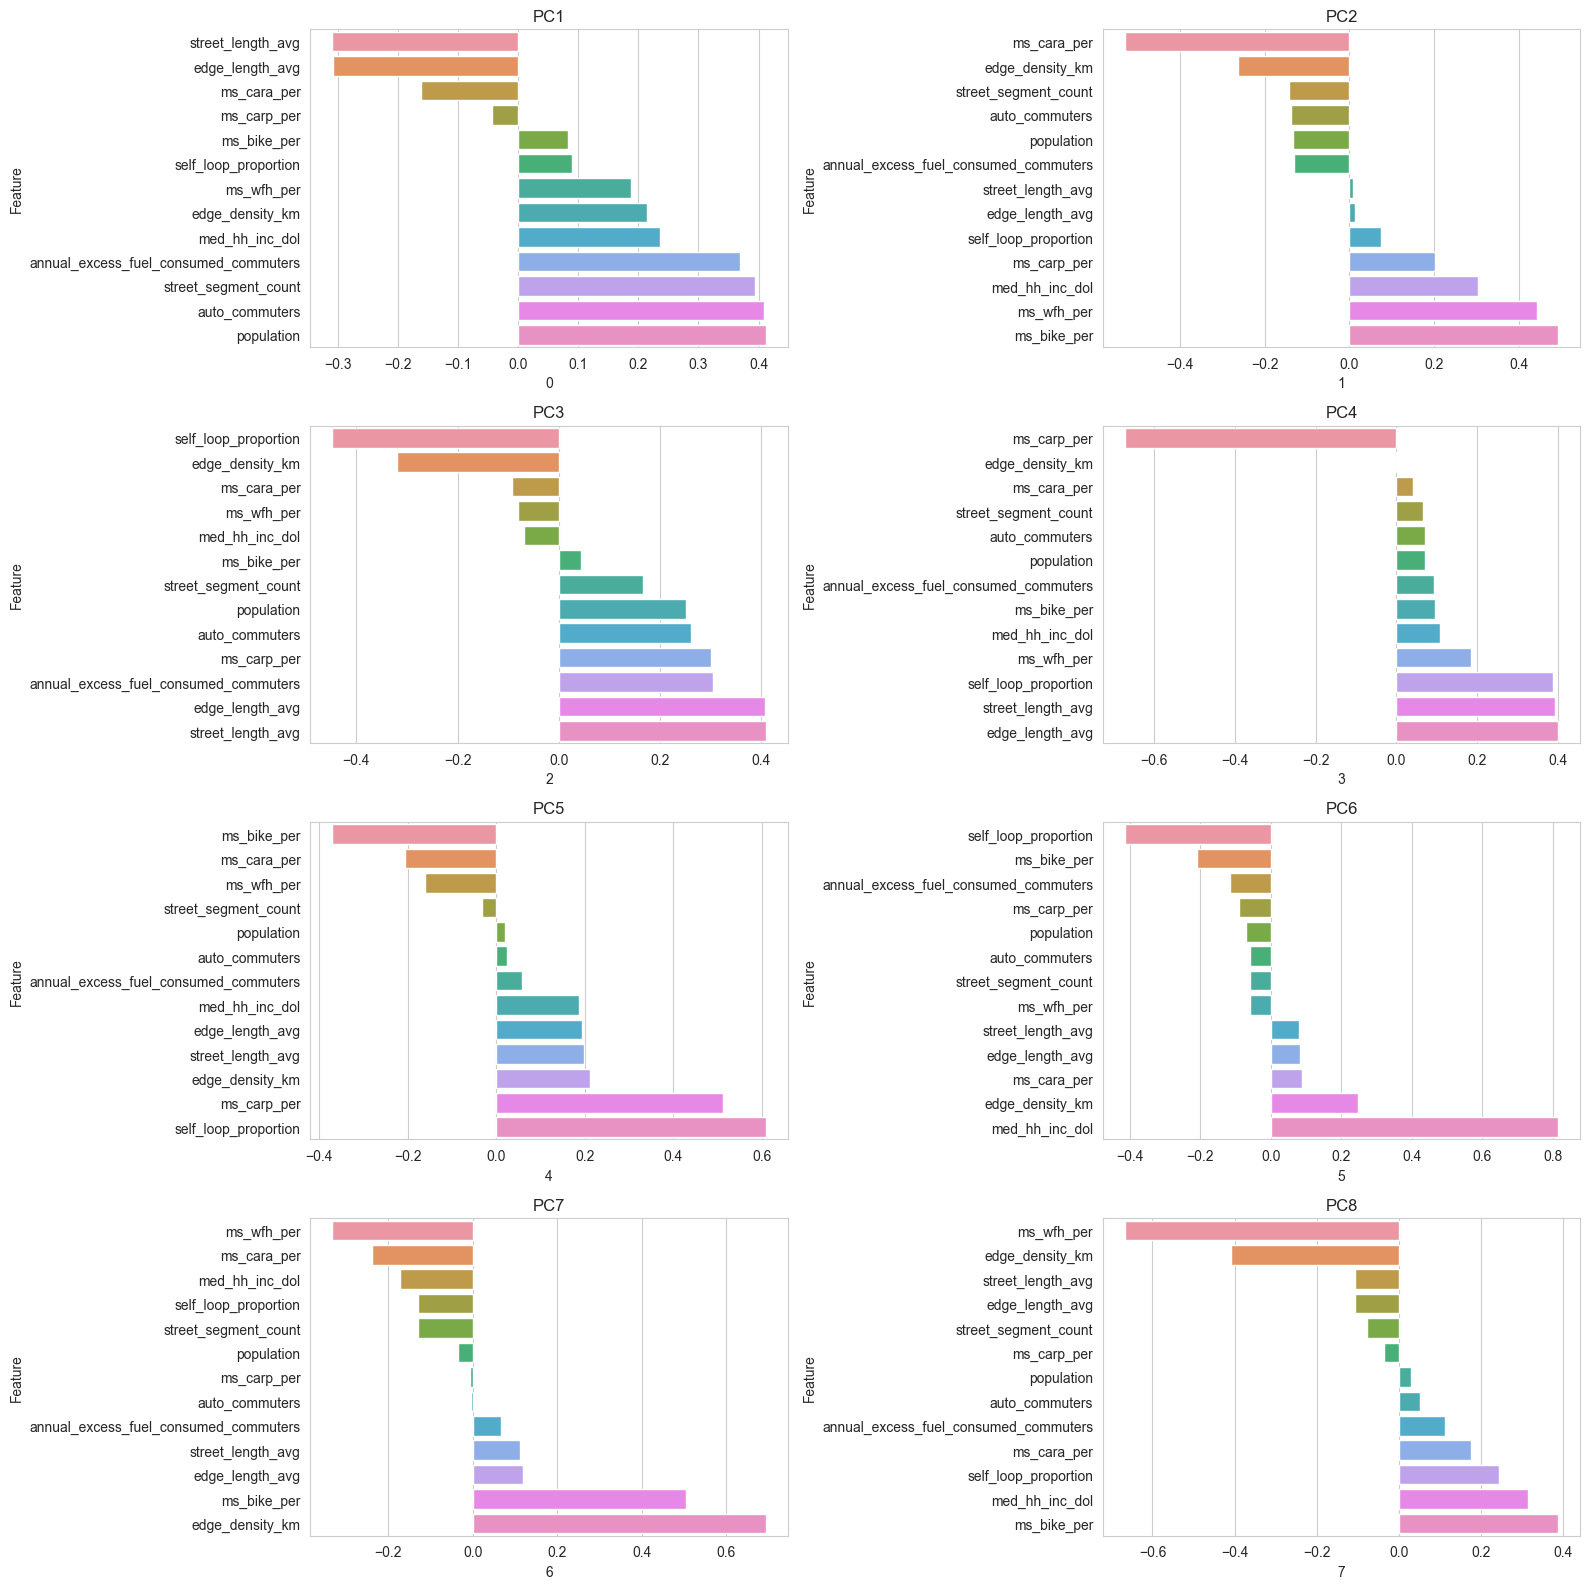

In [50]:
# Get the PCA loadings for the top 13 features
pca_components = pca.components_

# Create a DataFrame with the PCA loadings
loadings = pd.DataFrame(pca_components, columns=importances_df['Feature'][:num_important_features])
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))

# # PC1
# loadings.loc[0].sort_values().plot(kind='barh', ax=ax[0,0])
# ax[0,0].set_title('PC1')

for i in range(4):
    for j in range(2):
        # loadings.loc[i*2+j].sort_values().plot(kind='barh', ax=ax[i,j])
        # plot using seaborn
        sns.barplot(x=loadings.loc[i*2+j].sort_values(), y=loadings.loc[i*2+j].sort_values().index, ax=ax[i,j])
        ax[i,j].set_title('PC'+str(i*2+j+1))

plt.tight_layout()
plt.show()


### To interpret the loadings:
    - A high absolute value of a loading means that the variable strongly influences the component. 
    - The sign determines the direction of the influence.

Example:
- PC1: ahd_ph and annual_excess_fuel_consumed_commuters have strong positive loadings, while auto_commuters has a strong negative loading. This indicates that areas with high values of ahd_ph and annual_excess_fuel_consumed_commuters, and low values of auto_commuters, will have high values for PC1. The opposite is also true.

##### ***These were old observations***

- This interpretation of the loadings can help us understand how the original variables contribute to the new PCA features. 
    - However, these are not direct effects on the dependent variable, but on the principal components used in the PCR model.

    - To understand the effect of these variables on the target variable, we would need to consider the regression coefficients from the PCR model.
        - The interpretation would still not be straightforward because the features in the PCR are the principal components, not the original variables. 
        - The effect of each original variable on tti would be a combination of its loadings on the PCs and the PCR coefficients of those components. 
            - PCR coefficients are plotted below.

# Perform PCR after selecting the number of components

Train MAPE: 0.027641427379654217,
Test MAPE: 0.02873645557454829,
Train RMSE: 0.03987849810837847,
Test RMSE: 0.05077519737162677,
Train R2: 0.6711596705905529,
Test R2: 0.6242692225039518

Intercept:
 1.1165737051792828
Coefficients:
 [ 0.02407183  0.0067963   0.01118206 -0.00408337 -0.00126621  0.00983767
 -0.00606821  0.0072491 ]


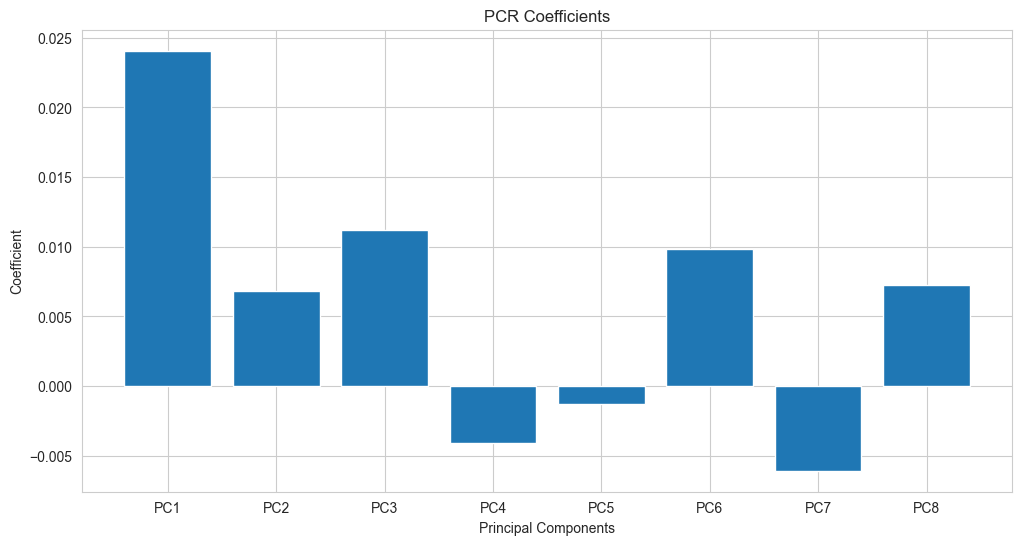

In [67]:
# keep the top 6 principal components
X_train_pca_4 = X_train_pca[:, :8]
X_test_pca_4 = X_test_pca[:, :8]

from sklearn.linear_model import LinearRegression

# Fit the PCR Model
pcr = LinearRegression()
pcr.fit(X_train_pca_4, y_train)

# Predictions
train_preds = pcr.predict(X_train_pca_4)
test_preds = pcr.predict(X_test_pca_4)

# Evaluation
mape_train = mean_absolute_percentage_error(y_train, train_preds)
mape_test = mean_absolute_percentage_error(y_test, test_preds)

rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

r2_train = r2_score(y_train, train_preds) 
r2_test = r2_score(y_test, test_preds)


print(f'Train MAPE: {mape_train},\nTest MAPE: {mape_test},\nTrain RMSE: {rmse_train},\nTest RMSE: {rmse_test},\nTrain R2: {r2_train},\nTest R2: {r2_test}')

# print the LinearRegression summary
print(f'\nIntercept:\n {pcr.intercept_}')
print(f'Coefficients:\n {pcr.coef_}')
plt.figure(figsize=(12, 6))
plt.bar(np.arange(8), pcr.coef_)
# set xticks to be the 8 principal components
plt.xticks(np.arange(8), ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
plt.xlabel('Principal Components')
plt.ylabel('Coefficient')
plt.title('PCR Coefficients')
plt.show()



## Analyze the PCR model results by plotting the observed vs predicted values for both the training and test sets.

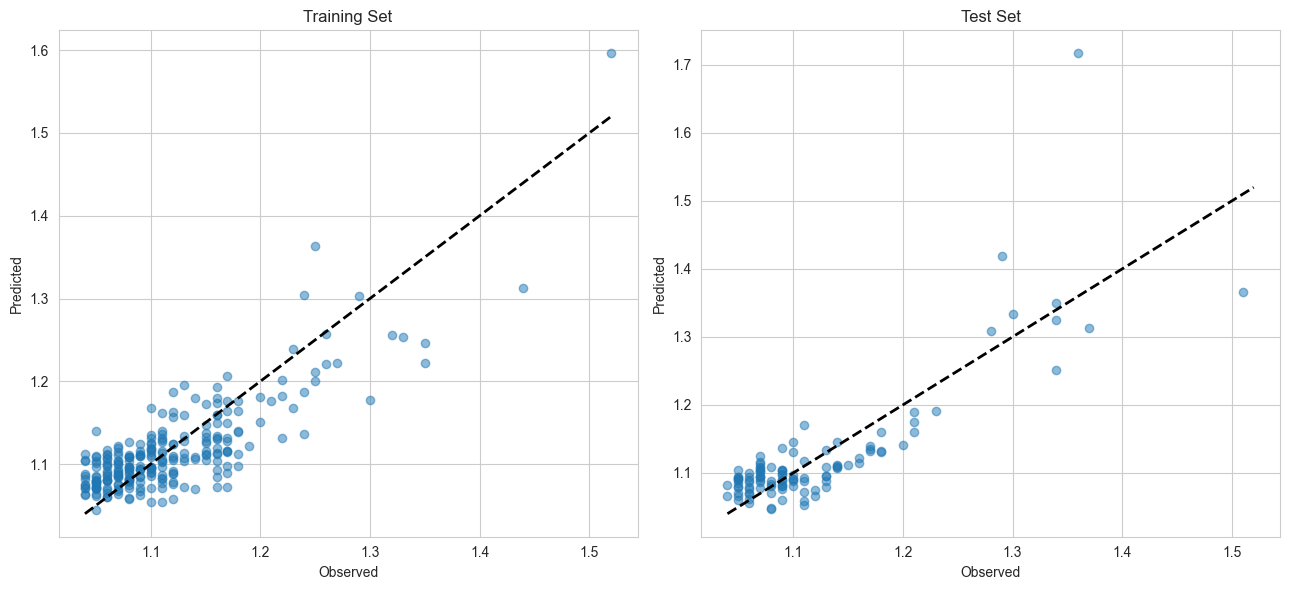

In [68]:
# Predictions
train_preds = pcr.predict(X_train_pca_4)
test_preds = pcr.predict(X_test_pca_4)

# Plot observed vs predicted values
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Training set
axs[0].scatter(y_train, train_preds, alpha=0.5)
axs[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axs[0].set_xlabel('Observed')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Training Set')

# Test set
axs[1].scatter(y_test, test_preds, alpha=0.5)
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axs[1].set_xlabel('Observed')
axs[1].set_ylabel('Predicted')
axs[1].set_title('Test Set')

plt.tight_layout()
plt.show()


- Training Set: The model seems to be doing reasonably well, with most points gathering around the 45 degree line

- Test Set: The model also appears to perform quite well on the test set, but there are some instances of both underprediction and overprediction.

## Result:
### 1. There isn't any clear pattern of misprediction.
#### 2. To further analyze the model, we can look at the residuals (differences between observed and predicted values). Patterns in residual plots provide insight into whether our model is capturing the relationships in the data well or not. 
    - Issues with the model like heteroscedasticity or outliers can be identified by examining the residual plots.

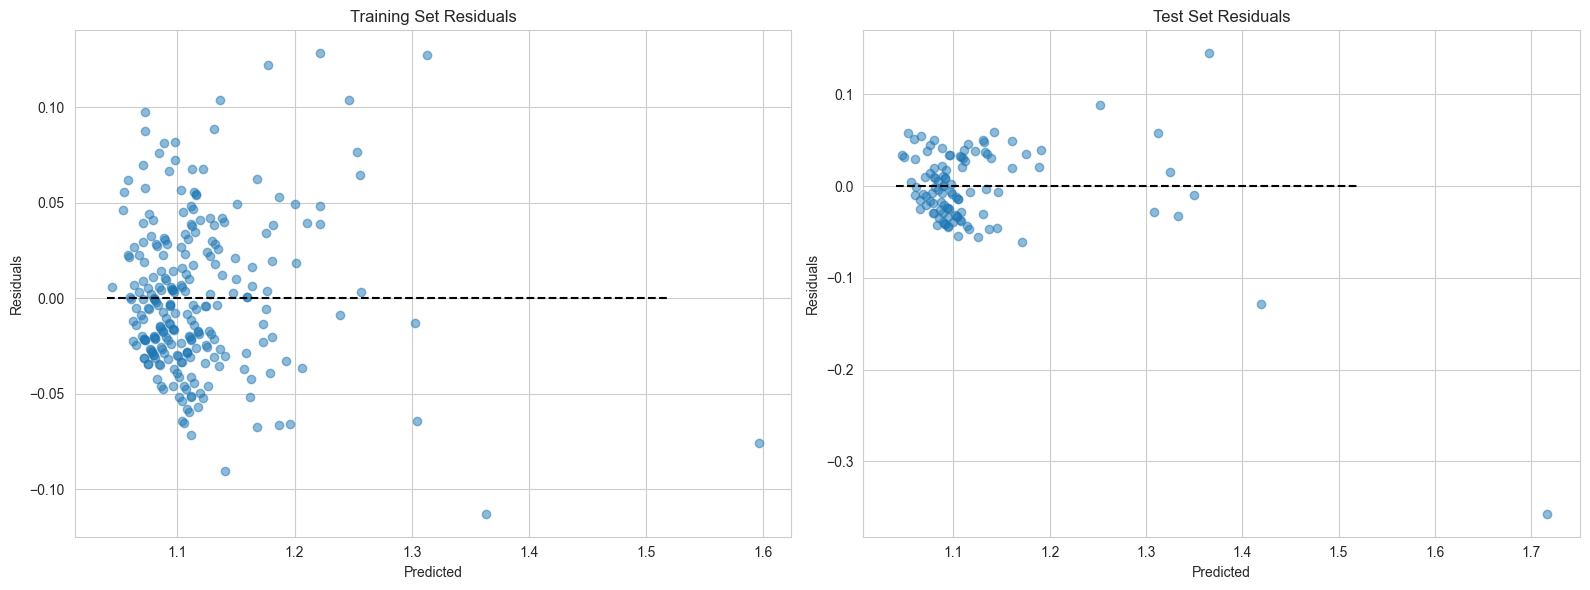

In [69]:
# Calculate residuals
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

# Plot residuals
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Training set
axs[0].scatter(train_preds, train_residuals, alpha=0.5)
axs[0].hlines(y=0, xmin=y.min(), xmax=y.max(), colors='k', linestyles='dashed')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Training Set Residuals')

# Test set
axs[1].scatter(test_preds, test_residuals, alpha=0.5)
axs[1].hlines(y=0, xmin=y.min(), xmax=y.max(), colors='k', linestyles='dashed')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Test Set Residuals')

plt.tight_layout()
plt.show()


#### **In a good model, we expect to see a random scatter of points with no clear patterns around the horizontal dashed line (residuals being randomly and normally distributed with a mean of zero.)**

Result:
- Training set: For most of the predicted values, the residuals seem to scatter randomly around the zero line.
- Test set: The residuals also seem to scatter randomly around the zero line. However, there are a few cases where our model significantly underpredicted or overpredicted the tti.

## Use gam PCR instead of linear?

In [ ]:

........
......
.....
...
